##### Copyright 2020 Google

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Making Molecule Files for HFVQE

In this tutorial we describe the process of making the molecular data files necessary to run the HFVQE code.  We focus on how to use the OpenFermion plugin modules to generate molecular files with canonical Hartree-Fock and generate integrals in a given atomic orbital basis set.  We also provide helper functions to run variational Hartree-Fock simulating the experiment and generating initial parameters.

This tutorial will follow the code in `recirq/hfvqe/molecular_data/` for constructing `MolecularData` objects and getting atomic orbital integrals.

In addition to the standard requirement of ReCirq and its dependencies, this notebook uses OpenFermion-pyscf (and pyscf) to compute some quantities. We install it below if you don't already have it.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/hfvqe/molecular_data"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/hfvqe/molecular_data.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/hfvqe/molecular_data.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/hfvqe/molecular_data.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

## Setup

In [2]:
try:
    import recirq
except ImportError:
    !pip install --quiet git+https://github.com/quantumlib/ReCirq
        
try:
    import openfermionpyscf
except ImportError:
    !pip install --quiet openfermionpyscf~=0.5.0

Now we can import the packages required for this notebook.

In [3]:
import os
import numpy as np
import scipy

from recirq.hfvqe.molecular_data.molecular_data_construction import (
    h6_linear_molecule, h8_linear_molecule, 
    h10_linear_molecule, h12_linear_molecule, 
    get_ao_integrals)
from recirq.hfvqe.gradient_hf import rhf_minimization, rhf_func_generator
from recirq.hfvqe.objective import RestrictedHartreeFockObjective, generate_hamiltonian

In [4]:
def make_rhf_objective(molecule):
    S, Hcore, TEI = get_ao_integrals(molecule)
    _, X = scipy.linalg.eigh(Hcore, S)

    molecular_hamiltonian = generate_hamiltonian(
        general_basis_change(Hcore, X, (1, 0)),
        numpy.einsum('psqr', general_basis_change(TEI, X, (1, 0, 1, 0)),
                     molecule.nuclear_repulsion))

    rhf_objective = RestrictedHartreeFockObjective(molecular_hamiltonian,
                                                   molecule.n_electrons)
    return rhf_objective, S, Hcore, TEI

## Hydrogen Chain MolecularData

We provide helper functions in the `hfvqe` module to generate the Hydrogen chain data.  Each chain is constructed using OpenFermion and Psi4 via the OpenFermion-Psi4 plugin.  We will use creating H6 with equal spacing between Hydrogen atoms as an example.  

In [5]:
from openfermion import MolecularData, general_basis_change
from openfermionpyscf import run_pyscf

In [6]:
n_hydrogens = 6
bond_distance = 1.3 # in Angstroms
molecule = MolecularData(
    geometry=[('H', (0, 0, i * bond_distance)) for i in range(n_hydrogens)],
    charge=0,
    basis='6-31g',
    multiplicity=1,
    description=f"linear_r-{bond_distance}")

The previous lines set up the MolecularData file.  We can now use pyscf to either run a full self-consistent-field Hartree-Fock calculation or get atomic integrals.  Via Openfermion-Pyscf we provide an interface to running Hartree-Fock, coupled-cluster, second order perturbation theory, configuration-interaction singles-doubles, and full configuration interaction.  Many of these methods depend on parameters such as convergence criteria or initial vectors in the subspace expansion.  `run_pyscf` assumes common defaults which are appropriate for most systems. Below we will run default Hartree-Fock and CISD.

In [7]:
molecule = run_pyscf(molecule, run_scf=True, run_cisd=True)
print("Hartree-Fock energy:", molecule.hf_energy, 
      "\nCISD energy:", molecule.cisd_energy)

Hartree-Fock energy: -3.1025910099208938 
CISD energy: -3.2221034851022194


The `MolecularData` file holds almost all information that is required for post-Hartree-Fock correlated calculations.  For example, we provide access to integrals as attributes of `MolecularData`.  

In [8]:
print("Overlap Ints")
print(molecule.overlap_integrals)

print()
print("One-electron integrals")
print(molecule.one_body_integrals)

Overlap Ints
[[1.00000000e+00 6.58292049e-01 1.07450262e-01 2.97950190e-01
  2.92936786e-04 2.79155456e-02 1.86658314e-08 5.52805483e-04
  2.50532789e-14 2.34306448e-06 7.06186034e-22 2.12361769e-09]
 [6.58292049e-01 1.00000000e+00 2.97950190e-01 6.14673658e-01
  2.79155456e-02 1.42750753e-01 5.52805483e-04 1.25256830e-02
  2.34306448e-06 4.15253811e-04 2.12361769e-09 5.20133758e-06]
 [1.07450262e-01 2.97950190e-01 1.00000000e+00 6.58292049e-01
  1.07450262e-01 2.97950190e-01 2.92936786e-04 2.79155456e-02
  1.86658314e-08 5.52805483e-04 2.50532789e-14 2.34306448e-06]
 [2.97950190e-01 6.14673658e-01 6.58292049e-01 1.00000000e+00
  2.97950190e-01 6.14673658e-01 2.79155456e-02 1.42750753e-01
  5.52805483e-04 1.25256830e-02 2.34306448e-06 4.15253811e-04]
 [2.92936786e-04 2.79155456e-02 1.07450262e-01 2.97950190e-01
  1.00000000e+00 6.58292049e-01 1.07450262e-01 2.97950190e-01
  2.92936786e-04 2.79155456e-02 1.86658314e-08 5.52805483e-04]
 [2.79155456e-02 1.42750753e-01 2.97950190e-01 6.146

For the Hartree-Fock experiment we will need to get the atomic basis integrals from the molecular integrals.  We can use the identity $C^{\dagger}SC = I$ to reverse the transformation on the one and two electron integrals.

In [9]:
oei_mo,  tei_mo = molecule.one_body_integrals, molecule.two_body_integrals
C = molecule.canonical_orbitals
S = molecule.overlap_integrals
oei_ao = general_basis_change(oei_mo, C.conj().T @ S, key=(1, 0))

In [10]:
print(oei_ao)

[[-1.18698197e+00 -1.09398249e+00 -2.90382070e-01 -5.73478152e-01
  -1.91588194e-03 -7.08618226e-02 -2.34028698e-07 -1.97458486e-03
  -5.37783138e-13 -1.18105831e-05 -6.86477567e-17 -1.46391009e-08]
 [-1.09398249e+00 -1.30863711e+00 -6.31325886e-01 -9.69723130e-01
  -7.72940958e-02 -2.75295274e-01 -2.08668247e-03 -2.98813560e-02
  -1.21151858e-05 -1.23417943e-03 -1.46391006e-08 -1.91822048e-05]
 [-2.90382070e-01 -6.31325886e-01 -1.51260669e+00 -1.30790890e+00
  -3.09964749e-01 -6.50637018e-01 -1.94571033e-03 -7.66467737e-02
  -2.34897054e-07 -2.06566594e-03 -5.37123491e-13 -1.21151858e-05]
 [-5.73478152e-01 -9.69723130e-01 -1.30790890e+00 -1.61455088e+00
  -6.69270617e-01 -1.08041337e+00 -7.82781452e-02 -2.89819977e-01
  -2.06566594e-03 -3.04640626e-02 -1.18105831e-05 -1.23417943e-03]
 [-1.91588194e-03 -7.72940958e-02 -3.09964749e-01 -6.69270617e-01
  -1.61437154e+00 -1.37489989e+00 -3.14983314e-01 -6.74320764e-01
  -1.94571033e-03 -7.82781452e-02 -2.34028698e-07 -2.08668247e-03]
 [-7.

In [11]:
print(oei_mo)

[[-1.87432470e+00 -1.44889294e-15 -1.16409641e-01 -6.93141072e-16
  -6.15072095e-02  8.08767162e-16 -1.25730762e-01 -9.32285111e-15
  -5.89306300e-02  1.01125399e-16  2.71517033e-03 -1.74496490e-15]
 [-1.43849427e-15 -1.69304399e+00 -3.44165915e-17  1.65551295e-01
   1.03793833e-15 -4.41326519e-02 -6.10215716e-15  1.00494584e-01
  -2.58912064e-15 -8.00969374e-02  2.38909615e-16 -6.99057737e-03]
 [-1.16409641e-01 -1.42546635e-16 -1.61481536e+00 -1.00731916e-15
   1.42976433e-01 -8.62841833e-16  1.99568166e-02 -1.43115243e-15
  -9.93300277e-02  1.76254334e-16 -8.38901334e-02 -8.84809878e-17]
 [-7.74841922e-16  1.65551295e-01 -1.00822702e-15 -1.47182180e+00
  -9.51785084e-16 -1.55554498e-01 -5.01061281e-15  6.81490634e-02
  -1.83879699e-15  1.47404734e-01 -1.24200242e-15 -4.83499815e-02]
 [-6.15072095e-02  8.87610437e-16  1.42976433e-01 -9.54187841e-16
  -1.29158710e+00 -2.42260991e-16  5.71957393e-02 -1.29996924e-16
  -1.32455830e-01 -1.05601168e-16  1.56350662e-01 -2.63047405e-15]
 [ 2.

In [12]:
# Use pyscf to get atomic integrals and compare to transformed integrals from above
pyscf_mol = molecule._pyscf_data['mol']
t = pyscf_mol.intor('int1e_kin')
v = pyscf_mol.intor('int1e_nuc')
hcore = t + v
assert np.allclose(hcore, oei_ao)

 The two-electron integrals can also be acquired from the `pyscf_mol` object or we can use the `general_basis_change` to transform the two-electron integrals back into the AO basis.

In [13]:
# Transform the two-electron integrals
tei_ao = general_basis_change(tei_mo, C.conj().T @ S, key=(1, 1, 0, 0))  

# re-ordering for chem->physics storage of the integrals
eri_ao = np.einsum('ijkl->iklj', pyscf_mol.intor('int2e', aosym='s1'))  

In [14]:
assert np.allclose(tei_ao, eri_ao)
assert not np.allclose(tei_ao, tei_mo)

We also provide a function in `recirq.hfvqe.molecular_data.molecular_data_construction` that uses psi4 to generate atomic integrals for the HF-VQE study.  Once the atomic orbital integrals are obtained we can perform the first step in setting up the HF-VQE experiment.  This involes transforming the integrals to the core-orbital basis and building an `RestrictedHartreeFockObjective`. 

In [15]:
# diagonalize the AO-core Hamiltonian
_, X = scipy.linalg.eigh(oei_ao, S)  

obi = general_basis_change(oei_ao, X, (1, 0))
tbi = np.einsum('psqr', general_basis_change(pyscf_mol.intor('int2e', aosym='s1'), X, (1, 0, 1, 0)))
molecular_hamiltonian = generate_hamiltonian(obi, tbi,
                                             molecule.nuclear_repulsion)

rhf_objective = RestrictedHartreeFockObjective(molecular_hamiltonian,
                                               molecule.n_electrons)

To get initial parameters we can simulate the Hartree-Fock experiment which is performing variational-Hartree-Fock theory.

In [16]:
from recirq.hfvqe.gradient_hf import rhf_minimization, rhf_func_generator
# Uses conjugate gradient to solve non-linear hartree-fock functional:
scipy_result = rhf_minimization(rhf_objective, verbose=True)  

Optimization terminated successfully.
         Current function value: -3.102591
         Iterations: 12
         Function evaluations: 25
         Gradient evaluations: 25


In [17]:
print(molecule.hf_energy, scipy_result.fun)

-3.1025910099208938 -3.1025910099026555


In [18]:
print("Initial Parameters for HF-VQE Study ", scipy_result.x)

Initial Parameters for HF-VQE Study  [ 9.63447262e-20 -4.73763008e-01  1.49945266e-19 -1.36102259e-02
  2.03739138e-20  4.44832962e-01 -6.49889110e-21 -2.59144562e-01
  1.14732050e-19  1.17062375e-01  1.23624217e-20  7.61172515e-03
 -5.00611233e-20  9.47442448e-02  2.38503164e-20 -2.71237044e-04
 -3.85097230e-20 -7.30836703e-02 -2.10434531e-19 -4.10271133e-02
  8.67744493e-20 -4.52955413e-03  2.75170240e-22 -8.54284651e-02
  6.27485736e-20 -4.71103578e-02  2.07313981e-20]


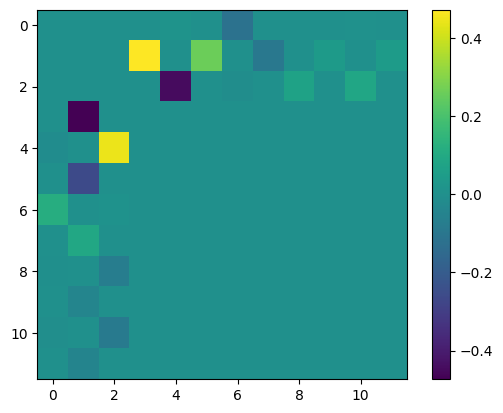

In [19]:
# Explicitly build kappa matrix
from recirq.hfvqe.circuits import rhf_params_to_matrix
import matplotlib.pyplot as plt
kappa = rhf_params_to_matrix(scipy_result.x, len(rhf_objective.occ) + len(rhf_objective.virt), rhf_objective.occ,
            rhf_objective.virt)
plt.imshow(kappa)
plt.colorbar()

In [20]:
rhf_objective.occ

[0, 1, 2]

In [21]:
rhf_objective.virt

[3, 4, 5, 6, 7, 8, 9, 10, 11]

In [22]:
help(rhf_params_to_matrix)

Help on function rhf_params_to_matrix in module recirq.hfvqe.circuits:

rhf_params_to_matrix(parameters: numpy.ndarray, num_qubits: int, occ: Optional[List[int]] = None, virt: Optional[List[int]] = None)
    Assemble variational parameters into a matrix.

    For restricted Hartree-Fock we have nocc * nvirt parameters. These are
    provided as a list that is ordered by (virtuals)    imes (occupied) where
    occupied is a set of indices corresponding to the occupied orbitals w.r.t
    the Lowdin basis and virtuals is a set of indices of the virtual orbitals
    w.r.t the Lowdin basis.  For example, for H4 we have 2 orbitals occupied and
    2 virtuals:

    occupied = [0, 1]  virtuals = [2, 3]

    parameters = [(v_{0}, o_{0}), (v_{0}, o_{1}), (v_{1}, o_{0}),
                  (v_{1}, o_{1})]
               = [(2, 0), (2, 1), (3, 0), (3, 1)]

    You can think of the tuples of elements of the upper right triangle of the
    antihermitian matrix that specifies the c_{b, i} coefficients